The features extracted from the sound, are collated into a csv file which would act as an input to the modelling process.

In [19]:
# import required libraries

# utilities
import numpy as np
import random
import pandas as pd
import os

# stats
from scipy.stats import norm

# plotting
import matplotlib.pyplot as plt

# scikit - model development
# preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, normalize

# Classification models
from sklearn.ensemble import AdaBoostClassifier,VotingClassifier,BaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier,ExtraTreesClassifier,StackingClassifier
from sklearn.neighbors import KNeighborsClassifier, NearestCentroid
from sklearn.naive_bayes import GaussianNB
from sklearn.multioutput import  MultiOutputClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC

#Clustering models
from sklearn.cluster import KMeans
from kneed import KneeLocator

#metrics
from sklearn.model_selection import RepeatedStratifiedKFold, GridSearchCV, cross_val_score
from sklearn.metrics import roc_curve,auc,accuracy_score, roc_auc_score, f1_score
from sklearn.metrics import classification_report

import shap

In [20]:
# Initialize common variables
num_trials = 20
seed_value = 123467
scaler_obj = MinMaxScaler(feature_range=(0, 1))

# Set file paths
root_path = "D:/PhD Program/Final Research/OLR/"
data_file_path = root_path + "DS_1_Feature_MFCC_no_hilbert_trans.csv"
data_file_path_ht = root_path + "DS_1_Feature_MFCC_hilbert_trans.csv"

os.chdir(root_path)

# set random seed
random.seed(seed_value)
np.random.seed(seed_value)

In [4]:
############################## Raw Data ##########################################################
# read the dataset - raw data
data_df_raw = pd.read_csv(data_file_path)

# Convert the sound_file_class label into a ordinal variable 
data_df_raw['sound_file_class_num'] = data_df_raw.apply(lambda x: 1 if x.sound_file_class=='Q1' 
                                                        else (2 if x.sound_file_class=='Q2' 
                                                              else (3 if x.sound_file_class=='Q3' else 4)), axis=1)

# derive a 3 level depdendent variable - combining Q3 & Q4 into a single class and Q1 & Q2 as seperate - 
# This will create class imbalance, needs to be handled apprpriately later

data_df_raw['new_sound_file_class'] = data_df_raw.apply(lambda x: 0 if x.sound_file_class=='Q2' else 1, axis=1)

X_raw = data_df_raw[data_df_raw.columns[~data_df_raw.columns.isin(['sound_file_name', 'sound_file_class','sound_file_class_num',
                                                                   'new_sound_file_class','class_name','track id',' genre', 
                                                                   'genre_name'])]]
# Replace null values with 0
null_cols = X_raw.select_dtypes(np.number).columns
X_raw[null_cols] = X_raw[null_cols].fillna(0)
#X_raw = X_raw.fillna(0)
X_raw_orig = X_raw

# scale the dataset
X_raw_scaled = scaler_obj.fit(X_raw)
X_raw_orig_scaled = pd.DataFrame(X_raw_scaled.transform(X_raw), columns = X_raw.columns)
############################## Hibert Transformed Data ##########################################################
# read the dataset - Hilbert Transformed data

data_df_ht = pd.read_csv(data_file_path_ht)
# Convert the sound_file_class label into a ordinal variable 
data_df_ht['sound_file_class_num'] = data_df_ht.apply(lambda x: 1 if x.sound_file_class=='Q1' 
                                                        else (2 if x.sound_file_class=='Q2' 
                                                              else (3 if x.sound_file_class=='Q3' else 4)), axis=1)

# derive a 3 level depdendent variable - combining Q3 & Q4 into a single class and Q1 & Q2 as seperate - 
# This will create class imbalance, needs to be handled apprpriately later

data_df_ht['new_sound_file_class'] = data_df_ht.apply(lambda x: 0 if x.sound_file_class=='Q2' else 1, axis=1)

X_ht = data_df_ht[data_df_ht.columns[~data_df_ht.columns.isin(['sound_file_name', 'sound_file_class','sound_file_class_num',
                                                               'new_sound_file_class','class_name','track id',' genre', 
                                                               'genre_name'])]]
# Replace null values with 0
null_cols = X_ht.select_dtypes(np.number).columns
X_ht[null_cols] = X_ht[null_cols].fillna(0)
#X_ht = X_ht.fillna(0)

X_ht_orig = X_ht

# scale the dataset
X_ht_scaled = scaler_obj.fit(X_ht)
X_ht_orig_scaled = pd.DataFrame(X_ht_scaled.transform(X_ht), columns = X_ht.columns)
############################## Factorize the target variable - emotion class/quadrant############################

# Transformed class variable (ordinal)
y,unique_vals = pd.factorize(data_df_raw['sound_file_class_num'], sort=True)

# Derived class variable
y_dicht,unique_vals = pd.factorize(data_df_raw['new_sound_file_class'], sort=True)

# Inital class variable
y_char,unique_vals = pd.factorize(data_df_raw['sound_file_class'], sort=True)
#y_new,unique_vals = pd.factorize(data_df['new_sound_file_class'], sort=True)



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [5]:
# EDA 1: Extract key features and its correponding value ranges

cols_format_to_extract = ['f0','plp','power','rms','spect_centroid','spect_rolloff','spect_flat','spect_bw','spect_contrast',
                          'tempo','zcr']
#measure_names = ['mean','median','max','min','sd','iqr']
measure_names = ['mean','median','max','min']
class_names = [1,2,3,4]
class_name_dict = {'Q1':1,
                  'Q2':2,
                  'Q3':3,
                  'Q4':4}
#feat_summary_df = pd.DataFrame(columns = ['class','feature','mean','median','max','sd','iqr'])
feat_summary_df = pd.DataFrame(columns = ['class','feature','mean','median','max'])
cols_to_ignore = []
for i in range(len(class_names)):
    #print(i+1)
    for key, val in class_name_dict.items():
        if val == i+1:
            class_val = key
            
    eda_df = data_df_raw[data_df_raw.sound_file_class==class_val]
    for col_name in cols_format_to_extract:
        val_ranges = []
        for measure_val in measure_names:
            #print(final_col_name)
            final_col_name = str(col_name)+"_"+measure_val
            try:
                min_val = round(np.min(eda_df[final_col_name]),3)
            except Exception as e:
                min_val = 0
            try:
                max_val = round(np.max(eda_df[final_col_name]),3)
            except Exception as e:
                max_val = 0
                
            if min_val == max_val:
                cols_to_ignore.append(final_col_name)
            val_range = str(min_val) + " - "+ str(max_val)
            val_ranges.append(val_range)

#         dict_tmp = {'feature':col_name,
#                     'class':class_val,
#                     'mean':val_ranges[0],
#                     'median':val_ranges[1],
#                     'max':val_ranges[2],
#                     'sd':val_ranges[3],
#                     'iqr':val_ranges[4]}

        dict_tmp = {'feature':col_name,
                    'class':class_val,
                    'mean':val_ranges[0],
                    'median':val_ranges[1],
                    'max':val_ranges[2]}
        
    #print(dict_tmp)
        feat_summary_df = feat_summary_df.append(dict_tmp, ignore_index=True)

# Identity range of values for each feature in each class
#print(cols_to_ignore)
feat_summary_df.to_csv(root_path+"feature_summary.csv",index=False)
#feat_summary_df
cols_to_ignore = list(set(cols_to_ignore))

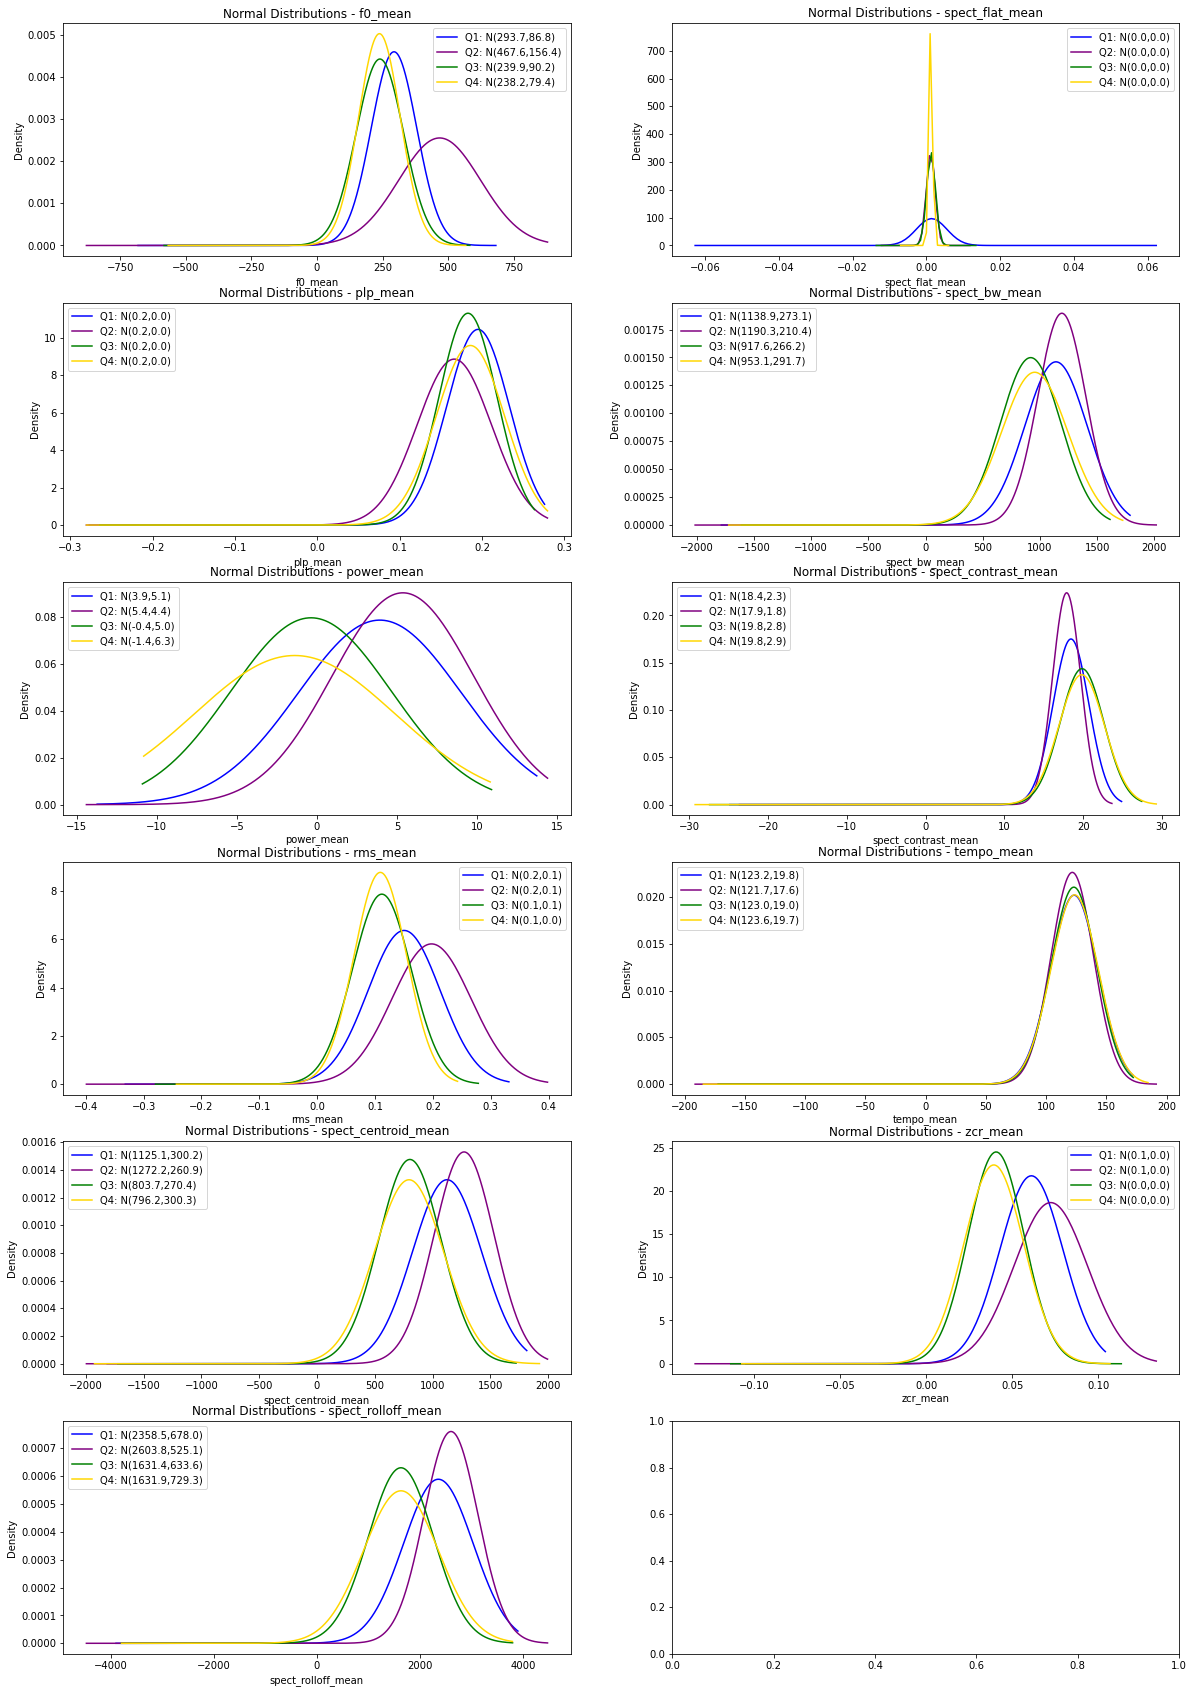

In [6]:
# EAD 2: plot normal distribution curve for core features: RMS, Power, Loudness and F0 

figure, axis = plt.subplots(6, 2, figsize= (20,30))
full_feat_cols = [['f0_mean','plp_mean','power_mean','rms_mean','spect_centroid_mean','spect_rolloff_mean'],
                 ['spect_flat_mean','spect_bw_mean','spect_contrast_mean','tempo_mean','zcr_mean']]

# class - validate class overlap
color_vals = ['blue','purple','green','gold']
#mean_cols = list(X_means.columns)
feat_col_cnt = 0
for feat_cols in full_feat_cols:
    #print(feat_cols)
    row_cnt = 0
    for col_val in feat_cols:
        cntr=0
        norm_df = data_df_raw[['sound_file_class',col_val]]

        for class_val in unique_vals:
            #print(class_val)
            class_df = norm_df[norm_df.sound_file_class==class_val]
            #print(class_df.head())
            mean_val = np.mean(class_df[col_val])
            sd_val = np.std(class_df[col_val])
            x = class_df[col_val]
            x_val = np.arange(max(x)*-1,max(x),0.001)
            label_val = str(class_val)+": N("+str(round(mean_val,1))+","+str(round(sd_val,1))+")"
            axis[row_cnt,feat_col_cnt].plot(x_val,norm.pdf(x_val,mean_val,sd_val),label = label_val, color=color_vals[cntr])    

            #plt.plot(x_val,norm.pdf(x_val,mean_val,sd_val),label = label_val, color=color_vals[cntr])    
            cntr +=1
        axis[row_cnt,feat_col_cnt].legend()
        axis[row_cnt,feat_col_cnt].set_ylabel("Density")
        axis[row_cnt,feat_col_cnt].set_xlabel(str(col_val))
        axis[row_cnt,feat_col_cnt].set_title("Normal Distributions - "+str(col_val))
        row_cnt +=1
    feat_col_cnt+=1
plt.show()

Comments:
1 Normal distribution plots indicate that there is significant class overlap between the classes Q3 and Q4
2 This class overlap can yield to lower accuracy in the model since the model may not be able to determine class boundaries
3 Kernel methods can be deployed to perform boundary detection but may not elevate the accuracy.
4 From a emotion detection stand point, this indicates 2 aspects:
    a Either the anotation of data was highly subjective OR
    b This overlap clearly indicates the bias involved where the detection of emotion boundaries varies with 
    the characterestics of each human brain. In addition, the classes Q3 and Q4 can be interpreted to be 
    inclined towards the "Sad" emotion as per Russel's Circumplex Model: (https://www.researchgate.net/profile/Jukka-Haekkinen/publication/262981399/figure/fig3/AS:392492835983380@1470588992866/Russells-circumplex-model-of-emotion.png).

Based on this perception, the class labels were re-classified into a ordinal variable with 
    a. "1" representing class "Q1"
    b. "2" representing class "Q2" and 
    c. "3" representing class "Q3" and "Q4".

In order to validate the 3 level re-classification of dependent variable, clustering (KMeans) is performed on the data to determine optimal clusters (elbow method) in the dataset using. MeanShift is also used as an additional method

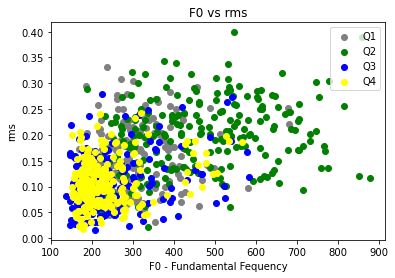

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
No handles with labels found to put in legend.


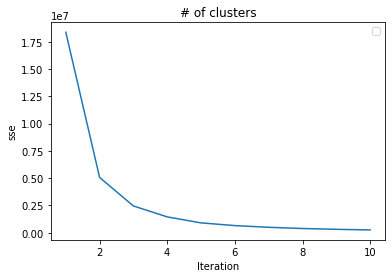

3

In [7]:
# EDA 3: Kmeans cluster to validate classes

#figure, axis = plt.subplots(6, 2, figsize= (20,30))

X = data_df_raw[['f0_mean','rms_mean','sound_file_class_num']]
X_class = X[X.sound_file_class_num==1]
x = X_class.f0_mean
y_class = X_class.rms_mean
plt.scatter(x,y_class,color="gray", label="Q1")
X_class = X[X.sound_file_class_num==2]
x = X_class.f0_mean
y_class = X_class.rms_mean
plt.scatter(x,y_class,color="green", label="Q2")
X_class = X[X.sound_file_class_num==3]
x = X_class.f0_mean
y_class = X_class.rms_mean
plt.scatter(x,y_class,color="blue", label="Q3")
X_class = X[X.sound_file_class_num==4]
x = X_class.f0_mean
y_class = X_class.rms_mean
plt.scatter(x,y_class,color="yellow", label="Q4")

plt.plot(figsize=(20,30))
plt.ylabel("rms")
plt.xlabel("F0 - Fundamental Fequency")
plt.title("F0 vs rms")
plt.legend()
plt.show()

sse_cluster = []
for k in range(1,11,1):
    k_means_model = KMeans(n_clusters = k).fit(X)
    sse_cluster.append(k_means_model.inertia_)
plt.plot(range(1,11,1),sse_cluster)
plt.ylabel("sse")
plt.xlabel("Iteration")
plt.title("# of clusters")
plt.legend()
plt.show()

# Find elbow locator
l1 = KneeLocator(range(1,11), sse_cluster, curve='convex',direction = 'decreasing')
l1.elbow

MeanShift(bandwidth=65)
{0, 1, 2, 3}


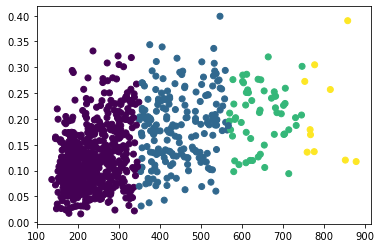

In [8]:
# EDA 4: Meanshift clustering to validate clusters
from sklearn.cluster import MeanShift

clust_model  = MeanShift(bandwidth=65).fit(X)
print(clust_model)
 
# SSpectralClustering(affinity='rbf', assign_labels='kmeans', coef0=1, degree=3,
#                    eigen_solver=None, eigen_tol=0.0, gamma=1.0,
#                    kernel_params=None, n_clusters=4, n_components=None,
#                    n_init=10, n_jobs=None, n_neighbors=10, random_state=None)

labels = clust_model.labels_
print(set(labels))
#plt.scatter(x[:,0], x[:,1], c=labels)
x = X.f0_mean
y_class = X.rms_mean
plt.scatter(x,y_class,c=labels)
plt.show()

-- Start the modelling
Start with AdaBoost
    - Determine optimal parameters using Grid Search
    - Once the optimal parameters are found, determine the model robustness using 
      multiple samples drawn from the train dataset and validating it against a test
      dataset which is extracted and kept as anonymous to the training process
    - Repeat the above steps for 6 different datasets viz. 
       1. raw dataset with full features, 
       2. hilbert transformed dataset with full features
       3. raw dataset with only "mean" features
       4. hilbert transformed data with only "mean" features
       5. raw dataset with a subset of "mean"features and 
       6. hilbert transformed data with a subset of "mean"features

In [9]:
     
# prepare dataset for modelling - by eliminating columns that contained constant values
X_raw_orig = X_raw_orig[X_raw_orig.columns[~X_raw_orig.columns.isin(cols_to_ignore)]]
X_ht_orig = X_ht_orig[X_ht_orig.columns[~X_ht_orig.columns.isin(cols_to_ignore)]]
X_raw_orig_scaled = X_raw_orig_scaled[X_raw_orig_scaled.columns[~X_raw_orig_scaled.columns.isin(cols_to_ignore)]]
X_ht_orig_scaled = X_ht_orig_scaled[X_ht_orig_scaled.columns[~X_ht_orig_scaled.columns.isin(cols_to_ignore)]]

metrics_df = pd.DataFrame(columns=['dataset', 'model','num_classes','feature_set' ,
                                   'num_feat', 'acc_range', 'auc_range','f1s_range','all_acc'])

In [10]:
# Adaboost classifiers - find the optimal parameters using unscaled raw data 

X = X_raw_orig

# X_raw = X_raw_orig.loc[:,X_raw_orig.columns.str.contains("_mean")]
# X_means_raw = X_raw_orig.loc[:,X_raw_orig.columns.str.contains("_mean")]
# X_raw = X_means_raw[['f0_mean','rms_mean', 'spect_centroid_mean','spect_rolloff_mean',
#                        'spect_contrast_mean','zcr_mean', 'power_mean','loudness_mean','chromagram_mean']]        

# X = X_raw

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,stratify=y)

# Initial parameters
# gs_parm_grid = {'n_estimators':[10,20,50,100,200,500,1000],
#                'learning_rate':[0.0001,0.001,0.01,0.1,1]}

gs_parm_grid = {'n_estimators':[100,200,500,800,1000,1500],
               'learning_rate':[0.01,0.05,0.1,0.2,0.3]}
ab_clf = AdaBoostClassifier()
cv_model = RepeatedStratifiedKFold(n_splits = 5, n_repeats=2,random_state=1)
grid_search_model_raw = GridSearchCV(estimator = ab_clf, 
                                 param_grid = gs_parm_grid, 
                                 n_jobs=1,
                                 cv=cv_model, 
                                 scoring = 'accuracy',
                                 verbose = 2)

grid_search_score_raw = grid_search_model_raw.fit(X,y)

# cv_scores = cross_val_score(ab_clf, X,y,scoring='accuracy',cv=cv_model,n_jobs=1,error_score='raise')

# print('Accuracy: %.3f (%.3f)' % (np.mean(cv_scores), np.std(cv_scores)))

print(grid_search_score_raw)
print("Best scores:")
print("Best: %f using %s" % (grid_search_score_raw.best_score_, grid_search_score_raw.best_params_))

Fitting 10 folds for each of 30 candidates, totalling 300 fits
[CV] END ...............learning_rate=0.01, n_estimators=100; total time=   3.2s
[CV] END ...............learning_rate=0.01, n_estimators=100; total time=   3.1s
[CV] END ...............learning_rate=0.01, n_estimators=100; total time=   3.1s
[CV] END ...............learning_rate=0.01, n_estimators=100; total time=   3.1s
[CV] END ...............learning_rate=0.01, n_estimators=100; total time=   3.1s
[CV] END ...............learning_rate=0.01, n_estimators=100; total time=   3.2s
[CV] END ...............learning_rate=0.01, n_estimators=100; total time=   3.1s
[CV] END ...............learning_rate=0.01, n_estimators=100; total time=   3.1s
[CV] END ...............learning_rate=0.01, n_estimators=100; total time=   3.1s
[CV] END ...............learning_rate=0.01, n_estimators=100; total time=   3.1s
[CV] END ...............learning_rate=0.01, n_estimators=200; total time=   6.2s
[CV] END ...............learning_rate=0.01, n_

[CV] END ..............learning_rate=0.05, n_estimators=1000; total time=  34.8s
[CV] END ..............learning_rate=0.05, n_estimators=1000; total time=  35.0s
[CV] END ..............learning_rate=0.05, n_estimators=1000; total time=  35.0s
[CV] END ..............learning_rate=0.05, n_estimators=1000; total time=  38.2s
[CV] END ..............learning_rate=0.05, n_estimators=1000; total time=  35.2s
[CV] END ..............learning_rate=0.05, n_estimators=1000; total time=  31.8s
[CV] END ..............learning_rate=0.05, n_estimators=1000; total time=  31.6s
[CV] END ..............learning_rate=0.05, n_estimators=1000; total time=  31.8s
[CV] END ..............learning_rate=0.05, n_estimators=1000; total time=  31.6s
[CV] END ..............learning_rate=0.05, n_estimators=1500; total time=  48.4s
[CV] END ..............learning_rate=0.05, n_estimators=1500; total time=  48.7s
[CV] END ..............learning_rate=0.05, n_estimators=1500; total time=  47.4s
[CV] END ..............learn

[CV] END ................learning_rate=0.2, n_estimators=500; total time=  15.8s
[CV] END ................learning_rate=0.2, n_estimators=500; total time=  16.2s
[CV] END ................learning_rate=0.2, n_estimators=500; total time=  15.8s
[CV] END ................learning_rate=0.2, n_estimators=500; total time=  15.8s
[CV] END ................learning_rate=0.2, n_estimators=500; total time=  15.8s
[CV] END ................learning_rate=0.2, n_estimators=500; total time=  15.8s
[CV] END ................learning_rate=0.2, n_estimators=500; total time=  15.7s
[CV] END ................learning_rate=0.2, n_estimators=800; total time=  25.3s
[CV] END ................learning_rate=0.2, n_estimators=800; total time=  25.3s
[CV] END ................learning_rate=0.2, n_estimators=800; total time=  25.3s
[CV] END ................learning_rate=0.2, n_estimators=800; total time=  25.8s
[CV] END ................learning_rate=0.2, n_estimators=800; total time=  25.3s
[CV] END ................lea

For the sound data, with all features, the parameters for Ada Boost that returned best accuray of 0.534 are learning rate = 0.05 and n_estimators = 800. The parameters were derived based on a 5 fold cross validation with 2 repeats and performing a grid search based on learning rates of 0.01, 0.05, 0.1, 0.2, 0.3 and n_estimators of 100,200,500,800,1000 and 1500.

In [11]:
# Adaboost classifiers - find the optimal parameters using scaled raw data 

# X_raw = X_raw_orig.loc[:,X_raw_orig.columns.str.contains("_mean")]
# X_means_raw = X_raw_orig.loc[:,X_raw_orig.columns.str.contains("_mean")]
# X_raw = X_means_raw[['f0_mean','rms_mean', 'spect_centroid_mean','spect_rolloff_mean',
#                        'spect_contrast_mean','zcr_mean', 'power_mean','loudness_mean','chromagram_mean']]        

X = X_raw_orig_scaled

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,stratify=y)

# Initial parameters
# gs_parm_grid = {'n_estimators':[10,20,50,100,200,500,1000],
#                'learning_rate':[0.0001,0.001,0.01,0.1,1]}

gs_parm_grid = {'n_estimators':[100,200,500,800,1000,1500],
               'learning_rate':[0.01,0.05,0.1,0.2,0.3]}
ab_clf = AdaBoostClassifier()
cv_model = RepeatedStratifiedKFold(n_splits = 5, n_repeats=2,random_state=1)
grid_search_model_scaled = GridSearchCV(estimator = ab_clf, 
                                 param_grid = gs_parm_grid, 
                                 n_jobs=1,
                                 cv=cv_model, 
                                 scoring = 'accuracy',
                                 verbose = 2)

grid_search_score_scaled = grid_search_model_scaled.fit(X,y)

# cv_scores = cross_val_score(ab_clf, X,y,scoring='accuracy',cv=cv_model,n_jobs=1,error_score='raise')

# print('Accuracy: %.3f (%.3f)' % (np.mean(cv_scores), np.std(cv_scores)))

print(grid_search_score_scaled)
print("Best scores:")
print("Best: %f using %s" % (grid_search_score_scaled.best_score_, grid_search_score_scaled.best_params_))

Fitting 10 folds for each of 30 candidates, totalling 300 fits
[CV] END ...............learning_rate=0.01, n_estimators=100; total time=   3.2s
[CV] END ...............learning_rate=0.01, n_estimators=100; total time=   3.2s
[CV] END ...............learning_rate=0.01, n_estimators=100; total time=   3.2s
[CV] END ...............learning_rate=0.01, n_estimators=100; total time=   3.2s
[CV] END ...............learning_rate=0.01, n_estimators=100; total time=   3.2s
[CV] END ...............learning_rate=0.01, n_estimators=100; total time=   3.2s
[CV] END ...............learning_rate=0.01, n_estimators=100; total time=   3.3s
[CV] END ...............learning_rate=0.01, n_estimators=100; total time=   3.3s
[CV] END ...............learning_rate=0.01, n_estimators=100; total time=   3.1s
[CV] END ...............learning_rate=0.01, n_estimators=100; total time=   3.4s
[CV] END ...............learning_rate=0.01, n_estimators=200; total time=   6.7s
[CV] END ...............learning_rate=0.01, n_

[CV] END ..............learning_rate=0.05, n_estimators=1000; total time=  31.6s
[CV] END ..............learning_rate=0.05, n_estimators=1000; total time=  31.5s
[CV] END ..............learning_rate=0.05, n_estimators=1000; total time=  31.8s
[CV] END ..............learning_rate=0.05, n_estimators=1000; total time=  31.6s
[CV] END ..............learning_rate=0.05, n_estimators=1000; total time=  31.9s
[CV] END ..............learning_rate=0.05, n_estimators=1000; total time=  31.4s
[CV] END ..............learning_rate=0.05, n_estimators=1000; total time=  31.5s
[CV] END ..............learning_rate=0.05, n_estimators=1000; total time=  31.9s
[CV] END ..............learning_rate=0.05, n_estimators=1000; total time=  31.5s
[CV] END ..............learning_rate=0.05, n_estimators=1500; total time=  47.2s
[CV] END ..............learning_rate=0.05, n_estimators=1500; total time=  47.3s
[CV] END ..............learning_rate=0.05, n_estimators=1500; total time=  47.3s
[CV] END ..............learn

[CV] END ................learning_rate=0.2, n_estimators=500; total time=  15.9s
[CV] END ................learning_rate=0.2, n_estimators=500; total time=  15.7s
[CV] END ................learning_rate=0.2, n_estimators=500; total time=  16.4s
[CV] END ................learning_rate=0.2, n_estimators=500; total time=  20.0s
[CV] END ................learning_rate=0.2, n_estimators=500; total time=  23.2s
[CV] END ................learning_rate=0.2, n_estimators=500; total time=  20.6s
[CV] END ................learning_rate=0.2, n_estimators=500; total time=  18.4s
[CV] END ................learning_rate=0.2, n_estimators=800; total time=  30.2s
[CV] END ................learning_rate=0.2, n_estimators=800; total time=  25.6s
[CV] END ................learning_rate=0.2, n_estimators=800; total time=  25.1s
[CV] END ................learning_rate=0.2, n_estimators=800; total time=  25.2s
[CV] END ................learning_rate=0.2, n_estimators=800; total time=  25.3s
[CV] END ................lea

For the scaled sound data, with all features, the parameters for Ada Boost that returned best accuray of 0.534 are learning rate = 0.05 and n_estimators = 800. The parameters were derived based on a 5 fold cross validation with 2 repeats and performing a grid search based on learning rates of 0.01, 0.05, 0.1, 0.2, 0.3 and n_estimators of 100,200,500,800,1000 and 1500.

Does this mean that Adaboost is scaling agnostic or not sensitive to scaling ?

In [17]:
# Ada boosting classifier
model_name = "Ada Boosting"
dataset_names = ['raw','raw-scaled','ht','ht-scaled']
feature_sets = ['All','Mean','Mean Subset']
n_est, learn_rate = 800, 0.05
plot_dict = {}
for feat_set in feature_sets:
    X_raw = X_raw_orig
    X_raw_scaled = X_raw_orig_scaled
    X_ht = X_ht_orig
    X_ht_scaled = X_ht_orig_scaled
    if feat_set == 'Mean':
        X_raw = X_raw_orig.loc[:,X_raw_orig.columns.str.contains("_mean")]
        X_raw_scaled = X_raw_orig_scaled.loc[:,X_raw_orig_scaled.columns.str.contains("_mean")]
        X_ht = X_ht_orig.loc[:,X_ht_orig.columns.str.contains("_mean")]        
        X_ht_scaled = X_ht_orig_scaled.loc[:,X_ht_orig_scaled.columns.str.contains("_mean")]
    elif feat_set == 'Mean Subset':
        X_means_raw = X_raw_orig.loc[:,X_raw_orig.columns.str.contains("_mean")]
        X_means_scaled = X_raw_orig_scaled.loc[:,X_raw_orig_scaled.columns.str.contains("_mean")]
        X_raw = X_means_raw[['f0_mean','rms_mean', 'spect_centroid_mean','spect_rolloff_mean',
                               'spect_contrast_mean','zcr_mean', 'power_mean','loudness_mean']]        
        X_raw_scaled = X_means_scaled[['f0_mean','rms_mean', 'spect_centroid_mean','spect_rolloff_mean',
                               'spect_contrast_mean','zcr_mean', 'power_mean','loudness_mean']]
        X_means_ht = X_ht_orig.loc[:,X_ht_orig.columns.str.contains("_mean")]
        X_means_ht_scaled = X_ht_orig_scaled.loc[:,X_ht_orig_scaled.columns.str.contains("_mean")]
        
        X_ht = X_means_ht[['f0_mean','rms_mean', 'spect_centroid_mean','spect_rolloff_mean',
                               'spect_contrast_mean','zcr_mean', 'power_mean','loudness_mean']]        
        X_ht_scaled = X_means_ht_scaled[['f0_mean','rms_mean', 'spect_centroid_mean','spect_rolloff_mean',
                               'spect_contrast_mean','zcr_mean', 'power_mean','loudness_mean']]

    for data_pos_val in range(len(dataset_names)):
        X = X_raw
        if dataset_names[data_pos_val]=='raw-scaled':
            X = X_raw_scaled
        elif dataset_names[data_pos_val]=='ht':
            X = X_ht
        elif dataset_names[data_pos_val]=='ht-scaled':
            X = X_ht_scaled
            
#         X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,stratify=y)
#         num_feat = str(len(X_train.columns))
        #print(dataset_names[data_pos_val])
        avg_acc = []
        avg_auc = []
        avg_f1s = []
        plot_name = feat_set+"_"+dataset_names[data_pos_val]+"_"
        print("Featureset:"  +feat_set+ ", Dataset:" + str(dataset_names[data_pos_val]))
        for trial_num in range(30):
            X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,stratify=y)
            num_feat = str(len(X_train.columns))
            ab_clf = AdaBoostClassifier(n_estimators=n_est, learning_rate = learn_rate, random_state=0, algorithm="SAMME.R")
            ab_clf.fit(X_train,y_train)
            y_pred = ab_clf.predict(X_test)
            y_pred_prob = ab_clf.predict_proba(X_test)
            curr_acc = round(accuracy_score(y_test, y_pred),3)
            curr_auc = round(roc_auc_score(y_test, y_pred_prob, multi_class='ovr'),3)
            curr_f1s = round(f1_score(y_test,y_pred,average="weighted"),3)
            avg_acc.append(curr_acc)
            avg_auc.append(curr_auc)
            avg_f1s.append(curr_f1s)
        plot_dict_tmp = {plot_name+"acc":avg_acc,
                        plot_name+"auc":avg_auc,
                        plot_name+"f1s":avg_f1s}
        plot_dict.update(plot_dict_tmp)
        #print(classification_report(y_test,y_pred))
        avg_acc_val = str(round(np.mean(avg_acc),3))
        acc_range = str(np.min(avg_acc))+" - "+(str(np.max(avg_acc)))

        avg_auc_val = str(round(np.mean(avg_auc),3))
        auc_range = str(np.min(avg_auc))+" - "+(str(np.max(avg_auc)))

        avg_f1s_val = str(round(np.mean(avg_f1s),3))
        f1s_range = str(np.min(avg_f1s))+" - "+(str(np.max(avg_f1s)))

        dict_tmp = {'dataset':dataset_names[data_pos_val],
                    'model':model_name,
                    'num_classes':len(unique_vals),
                    'feature_set':feat_set,
                    'num_feat':num_feat,
                    'acc_range':avg_acc_val+" ("+acc_range+")",
                    'auc_range':avg_auc_val+" ("+auc_range+")",
                    'f1s_range':avg_f1s_val+" ("+f1s_range+")",
                   'all_acc':avg_acc}
    #print(dict_tmp)
        metrics_df = metrics_df.append(dict_tmp, ignore_index=True)
metrics_df.to_csv("model_metrics_4_classes.csv", index= False)
metrics_df

Featureset:All, Dataset:raw
Featureset:All, Dataset:raw-scaled
Featureset:All, Dataset:ht
Featureset:All, Dataset:ht-scaled
Featureset:Mean, Dataset:raw
Featureset:Mean, Dataset:raw-scaled
Featureset:Mean, Dataset:ht
Featureset:Mean, Dataset:ht-scaled
Featureset:Mean Subset, Dataset:raw
Featureset:Mean Subset, Dataset:raw-scaled
Featureset:Mean Subset, Dataset:ht
Featureset:Mean Subset, Dataset:ht-scaled


,dataset,model,num_classes,feature_set,num_feat,acc_range,auc_range,f1s_range,all_acc
0,raw,Ada Boosting,4,All,554,0.511 (0.426 - 0.593),0.762 (0.726 - 0.8),0.512 (0.432 - 0.594),"[0.493, 0.581, 0.5, 0.511, 0.581, 0.563, 0.511..."
1,raw,Ada Boosting,4,All,554,0.516 (0.433 - 0.559),0.763 (0.738 - 0.782),0.516 (0.431 - 0.559),"[0.544, 0.463, 0.544, 0.493, 0.559, 0.533, 0.5..."
2,raw,Ada Boosting,4,All,554,0.515 (0.467 - 0.552),0.767 (0.732 - 0.791),0.516 (0.468 - 0.547),"[0.504, 0.504, 0.552, 0.489, 0.485, 0.489, 0.5..."
3,raw-scaled,Ada Boosting,4,All,554,0.514 (0.444 - 0.559),0.765 (0.739 - 0.788),0.514 (0.451 - 0.562),"[0.533, 0.559, 0.559, 0.493, 0.533, 0.552, 0.5..."
4,ht,Ada Boosting,4,All,554,0.522 (0.459 - 0.581),0.765 (0.739 - 0.788),0.523 (0.461 - 0.583),"[0.559, 0.533, 0.578, 0.496, 0.481, 0.552, 0.5..."
5,ht-scaled,Ada Boosting,4,All,554,0.524 (0.452 - 0.585),0.77 (0.728 - 0.79),0.525 (0.447 - 0.587),"[0.519, 0.485, 0.511, 0.452, 0.556, 0.533, 0.5..."
6,raw,Ada Boosting,4,Mean,96,0.537 (0.493 - 0.604),0.766 (0.714 - 0.809),0.537 (0.485 - 0.603),"[0.5, 0.567, 0.537, 0.507, 0.552, 0.544, 0.548..."
7,raw-scaled,Ada Boosting,4,Mean,96,0.535 (0.493 - 0.593),0.773 (0.74 - 0.797),0.535 (0.492 - 0.594),"[0.541, 0.496, 0.541, 0.493, 0.493, 0.556, 0.5..."
8,ht,Ada Boosting,4,Mean,96,0.533 (0.47 - 0.593),0.763 (0.725 - 0.801),0.533 (0.474 - 0.592),"[0.541, 0.53, 0.53, 0.526, 0.496, 0.574, 0.563..."
9,ht-scaled,Ada Boosting,4,Mean,96,0.544 (0.493 - 0.593),0.772 (0.735 - 0.789),0.544 (0.487 - 0.592),"[0.537, 0.53, 0.552, 0.552, 0.574, 0.552, 0.49..."


In [35]:
plot_dict.keys()

dict_keys(['All_raw_acc', 'All_raw_auc', 'All_raw_f1s', 'All_raw-scaled_acc', 'All_raw-scaled_auc', 'All_raw-scaled_f1s', 'All_ht_acc', 'All_ht_auc', 'All_ht_f1s', 'All_ht-scaled_acc', 'All_ht-scaled_auc', 'All_ht-scaled_f1s', 'Mean_raw_acc', 'Mean_raw_auc', 'Mean_raw_f1s', 'Mean_raw-scaled_acc', 'Mean_raw-scaled_auc', 'Mean_raw-scaled_f1s', 'Mean_ht_acc', 'Mean_ht_auc', 'Mean_ht_f1s', 'Mean_ht-scaled_acc', 'Mean_ht-scaled_auc', 'Mean_ht-scaled_f1s', 'Mean Subset_raw_acc', 'Mean Subset_raw_auc', 'Mean Subset_raw_f1s', 'Mean Subset_raw-scaled_acc', 'Mean Subset_raw-scaled_auc', 'Mean Subset_raw-scaled_f1s', 'Mean Subset_ht_acc', 'Mean Subset_ht_auc', 'Mean Subset_ht_f1s', 'Mean Subset_ht-scaled_acc', 'Mean Subset_ht-scaled_auc', 'Mean Subset_ht-scaled_f1s'])

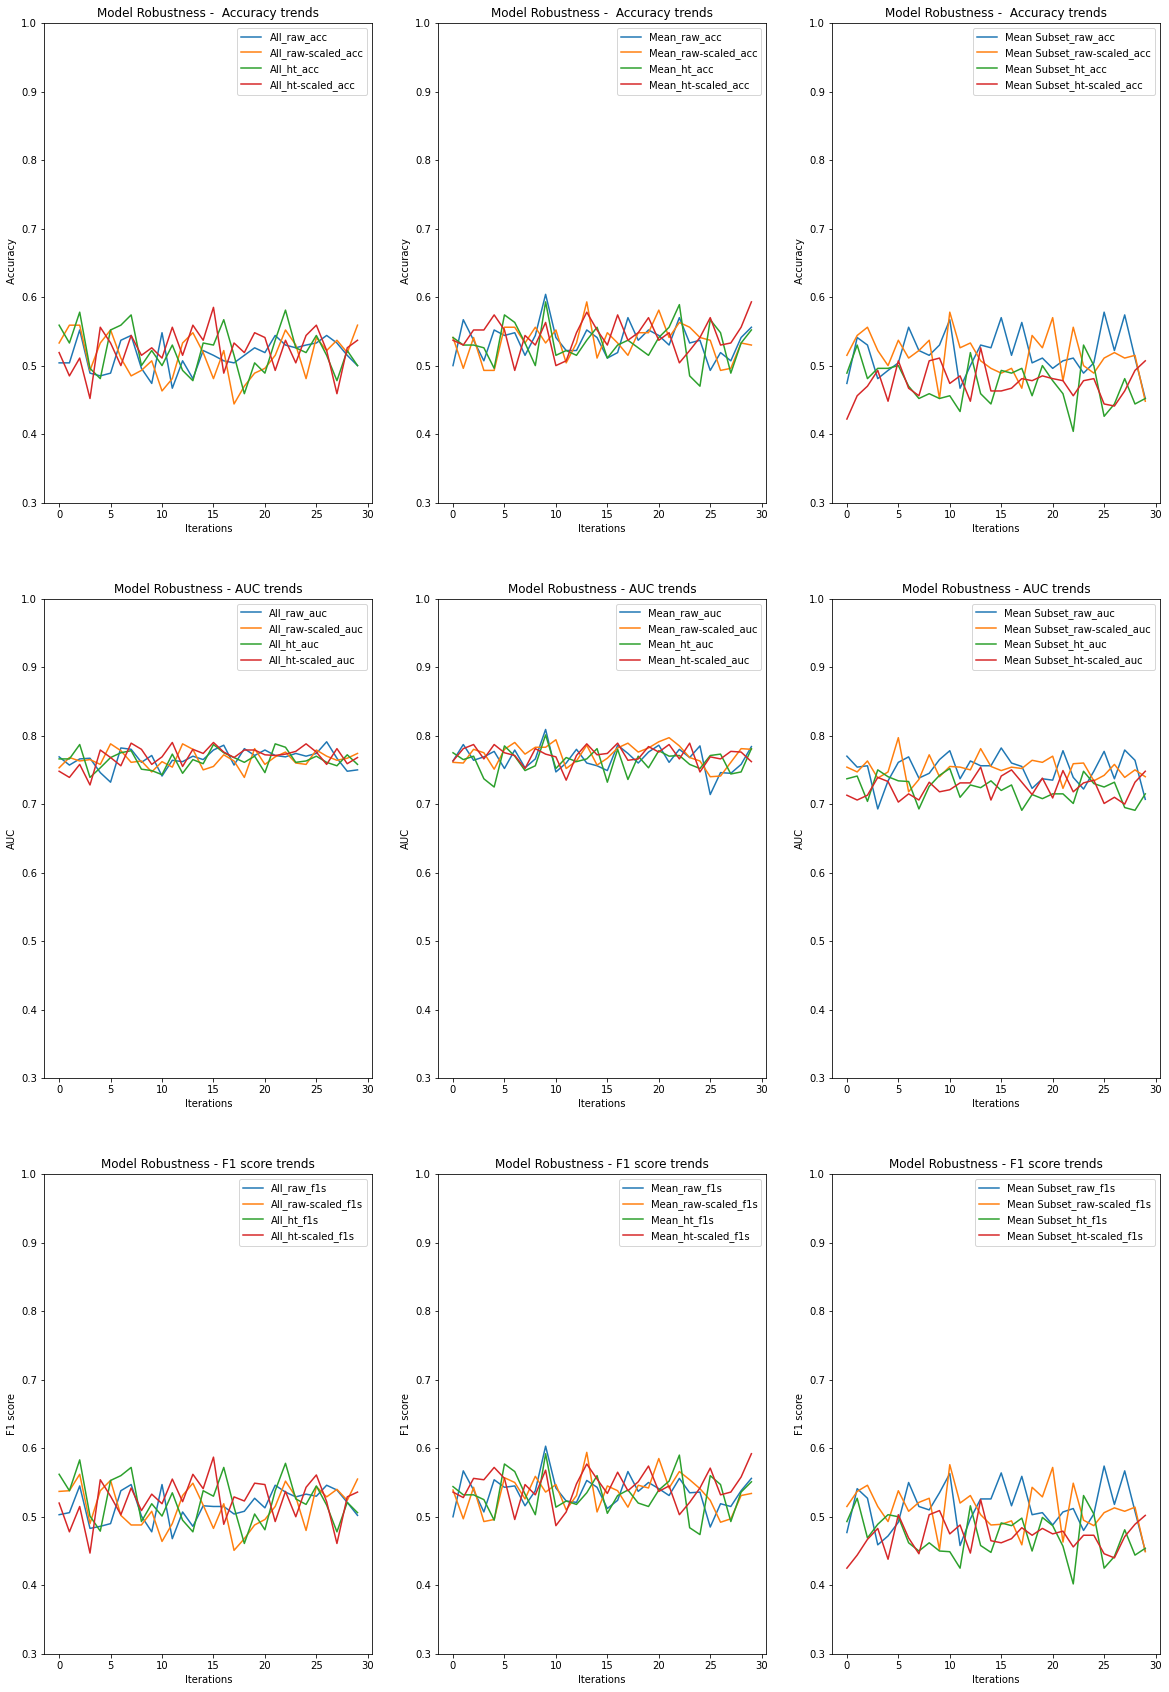

In [70]:
plot_keys = list(plot_dict.keys())
metrics_dict = {'_acc':" Accuracy",
                '_auc': "AUC",
                '_f1s': "F1 score"}

metrics_list = list(metrics_dict.keys())
x = range(0,len(y),1)

# Plot the accuracy trends - all feature datasets

fig_rows = len(metrics_list)
fig_cols = fig_rows

figure, axis = plt.subplots(fig_rows,fig_cols, figsize= (20,30))
row_cntr = 0
display_legend = False
for metric_val in metrics_list:
    feature_list = [plot_key for plot_key in plot_keys if plot_key.__contains__(metric_val)]       
    col_cntr = 0
    feat_cntr = 1
    for feature_name in feature_list:    
        y = plot_dict[feature_name]
        if feat_cntr%4==0:
            display_legend = True
        #print("["+str(row_cntr)+","+ str(col_cntr)+"]")
        axis[row_cntr, col_cntr].set_ylim(0.3,1)
        axis[row_cntr, col_cntr].plot(x, y,label=feature_name)
        feat_cntr +=1

        if display_legend == True:
            axis[row_cntr, col_cntr].legend()
            axis[row_cntr, col_cntr].set_ylabel(metrics_dict[metric_val])
            axis[row_cntr, col_cntr].set_xlabel("Iterations")
            axis[row_cntr, col_cntr].set_title("Model Robustness - " + str(metrics_dict[metric_val])+" trends")

            col_cntr+=1
            feat_cntr=1
            display_legend = False
        
    row_cntr += 1

In [ ]:
# Random Forest classifier
model_name = "Random Forest"
dataset_names = ['raw','ht']
feature_sets = ['All','Mean','Mean Subset']
for feat_set in feature_sets:
    X_raw = X_raw_orig
    X_ht = X_ht_orig
    if feat_set == 'Mean':
        X_raw = X_raw_orig.loc[:,X_raw_orig.columns.str.contains("_mean")]
        X_ht = X_ht_orig.loc[:,X_ht_orig.columns.str.contains("_mean")]
    elif feat_set == 'Mean Subset':
        X_means_raw = X_raw_orig.loc[:,X_raw_orig.columns.str.contains("_mean")]
        X_raw = X_means_raw[['f0_mean','rms_mean', 'spect_centroid_mean','spect_rolloff_mean',
                               'spect_contrast_mean','zcr_mean', 'power_mean','loudness_mean','chromagram_mean']]        
        X_means_ht = X_ht_orig.loc[:,X_ht_orig.columns.str.contains("_mean")]
        X_ht = X_means_raw[['f0_mean','rms_mean', 'spect_centroid_mean','spect_rolloff_mean',
                               'spect_contrast_mean','zcr_mean', 'power_mean','loudness_mean','chromagram_mean']]        

    for data_pos_val in range(len(dataset_names)):
        X = X_raw
        if dataset_names[data_pos_val]=='ht':
            X = X_ht
        X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,stratify=y)
        num_feat = str(len(X_train.columns))
        #print(dataset_names[data_pos_val])
        avg_acc = []
        avg_auc = []
        avg_f1s = []
        for trial_num in range(30):
            rf_clf = RandomForestClassifier(n_estimators=5000,
                                                max_depth=10,
                                                random_state=0,
                                                min_samples_split=0.05)

            rf_clf.fit(X_train,y_train)
            y_pred = rf_clf.predict(X_test)
            y_pred_prob = rf_clf.predict_proba(X_test)
            curr_acc = round(accuracy_score(y_test, y_pred),3)
            curr_auc = round(roc_auc_score(y_test, y_pred_prob, multi_class='ovr'),3)
            curr_f1s = round(f1_score(y_test,y_pred,average="weighted"),3)
            avg_acc.append(curr_acc)
            avg_auc.append(curr_auc)
            avg_f1s.append(curr_f1s)

        # Plot the acc variation trends: TBD
        
        #print(classification_report(y_test,y_pred))
        avg_acc_val = str(round(np.mean(avg_acc),3))
        acc_range = str(np.min(avg_acc))+" - "+(str(np.max(avg_acc)))

        avg_auc_val = str(round(np.mean(avg_auc),3))
        auc_range = str(np.min(avg_auc))+" - "+(str(np.max(avg_auc)))

        avg_f1s_val = str(round(np.mean(avg_f1s),3))
        f1s_range = str(np.min(avg_f1s))+" - "+(str(np.max(avg_f1s)))

        dict_tmp = {'dataset':dataset_names[data_pos_val],
                    'model':model_name,
                    'num_classes':len(unique_vals),
                    'feature_set':feat_set,
                    'num_feat':num_feat,
                    'acc_range':avg_acc_val+" ("+acc_range+")",
                    'auc_range':avg_auc_val+" ("+auc_range+")",
                    'f1s_range':avg_f1s_val+" ("+f1s_range+")"}
    #print(dict_tmp)
        metrics_df = metrics_df.append(dict_tmp, ignore_index=True)

metrics_df

In [ ]:
# Gradient boosting classifier
model_name = "Gradient Boosting"
dataset_names = ['raw','ht']
feature_sets = ['All','Mean','Mean Subset']
for feat_set in feature_sets:
    X_raw = X_raw_orig
    X_ht = X_ht_orig
    if feat_set == 'Mean':
        X_raw = X_raw_orig.loc[:,X_raw_orig.columns.str.contains("_mean")]
        X_ht = X_ht_orig.loc[:,X_ht_orig.columns.str.contains("_mean")]
    elif feat_set == 'Mean Subset':
        X_means_raw = X_raw_orig.loc[:,X_raw_orig.columns.str.contains("_mean")]
        X_raw = X_means_raw[['f0_mean','rms_mean', 'spect_centroid_mean','spect_rolloff_mean',
                               'spect_contrast_mean','zcr_mean', 'power_mean','loudness_mean','chromagram_mean']]        
        X_means_ht = X_ht_orig.loc[:,X_ht_orig.columns.str.contains("_mean")]
        X_ht = X_means_raw[['f0_mean','rms_mean', 'spect_centroid_mean','spect_rolloff_mean',
                               'spect_contrast_mean','zcr_mean', 'power_mean','loudness_mean','chromagram_mean']]        

    for data_pos_val in range(len(dataset_names)):
        X = X_raw
        if dataset_names[data_pos_val]=='ht':
            X = X_ht
        X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,stratify=y)
        num_feat = str(len(X_train.columns))
        #print(dataset_names[data_pos_val])
        avg_acc = []
        avg_auc = []
        avg_f1s = []
        for trial_num in range(30):
            gb_clf = GradientBoostingClassifier()
            gb_clf.fit(X_train,y_train)
            y_pred = gb_clf.predict(X_test)
            y_pred_prob = gb_clf.predict_proba(X_test)
            curr_acc = round(accuracy_score(y_test, y_pred),3)
            curr_auc = round(roc_auc_score(y_test, y_pred_prob, multi_class='ovr'),3)
            curr_f1s = round(f1_score(y_test,y_pred,average="weighted"),3)
            avg_acc.append(curr_acc)
            avg_auc.append(curr_auc)
            avg_f1s.append(curr_f1s)
        
        # Plot the acc variation trends: TBD
        
        #print(classification_report(y_test,y_pred))
        avg_acc_val = str(round(np.mean(avg_acc),3))
        acc_range = str(np.min(avg_acc))+" - "+(str(np.max(avg_acc)))

        avg_auc_val = str(round(np.mean(avg_auc),3))
        auc_range = str(np.min(avg_auc))+" - "+(str(np.max(avg_auc)))

        avg_f1s_val = str(round(np.mean(avg_f1s),3))
        f1s_range = str(np.min(avg_f1s))+" - "+(str(np.max(avg_f1s)))

        dict_tmp = {'dataset':dataset_names[data_pos_val],
                    'model':model_name,
                    'num_classes':len(unique_vals),
                    'feature_set':feat_set,
                    'num_feat':num_feat,
                    'acc_range':avg_acc_val+" ("+acc_range+")",
                    'auc_range':avg_auc_val+" ("+auc_range+")",
                    'f1s_range':avg_f1s_val+" ("+f1s_range+")"}
    #print(dict_tmp)
        metrics_df = metrics_df.append(dict_tmp, ignore_index=True)

metrics_df

In [ ]:
# SVC classifier - linear kernel
model_name = "One Vs Rest - RBF"
dataset_names = ['raw','ht']
feature_sets = ['All','Mean','Mean Subset']
for feat_set in feature_sets:
    X_raw = X_raw_orig
    X_ht = X_ht_orig
    if feat_set == 'Mean':
        X_raw = X_raw_orig.loc[:,X_raw_orig.columns.str.contains("_mean")]
        X_ht = X_ht_orig.loc[:,X_ht_orig.columns.str.contains("_mean")]
    elif feat_set == 'Mean Subset':
        X_means_raw = X_raw_orig.loc[:,X_raw_orig.columns.str.contains("_mean")]
        X_raw = X_means_raw[['f0_mean','rms_mean', 'spect_centroid_mean','spect_rolloff_mean',
                               'spect_contrast_mean','zcr_mean', 'power_mean','loudness_mean','chromagram_mean']]        
        X_means_ht = X_ht_orig.loc[:,X_ht_orig.columns.str.contains("_mean")]
        X_ht = X_means_raw[['f0_mean','rms_mean', 'spect_centroid_mean','spect_rolloff_mean',
                               'spect_contrast_mean','zcr_mean', 'power_mean','loudness_mean','chromagram_mean']]        

    for data_pos_val in range(len(dataset_names)):
        X = X_raw
        if dataset_names[data_pos_val]=='ht':
            X = X_ht
        X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,stratify=y)
        num_feat = str(len(X_train.columns))
        #print(dataset_names[data_pos_val])
        avg_acc = []
        avg_auc = []
        avg_f1s = []
        for trial_num in range(30):
            clf_ovr = SVC(probability=True)
            clf_ovr.fit(X_train,y_train)

            y_pred = clf_ovr.predict(X_test)
            y_pred_prob = clf_ovr.predict_proba(X_test)
            curr_acc = round(accuracy_score(y_test, y_pred),3)
            curr_auc = round(roc_auc_score(y_test, y_pred_prob, multi_class='ovr'),3)
            curr_f1s = round(f1_score(y_test,y_pred,average="weighted"),3)
            avg_acc.append(curr_acc)
            avg_auc.append(curr_auc)
            avg_f1s.append(curr_f1s)
        
        # Plot the acc variation trends: TBD
        
        #print(classification_report(y_test,y_pred))
        avg_acc_val = str(round(np.mean(avg_acc),3))
        acc_range = str(np.min(avg_acc))+" - "+(str(np.max(avg_acc)))

        avg_auc_val = str(round(np.mean(avg_auc),3))
        auc_range = str(np.min(avg_auc))+" - "+(str(np.max(avg_auc)))

        avg_f1s_val = str(round(np.mean(avg_f1s),3))
        f1s_range = str(np.min(avg_f1s))+" - "+(str(np.max(avg_f1s)))

        dict_tmp = {'dataset':dataset_names[data_pos_val],
                    'model':model_name,
                    'num_classes':len(unique_vals),
                    'feature_set':feat_set,
                    'num_feat':num_feat,
                    'acc_range':avg_acc_val+" ("+acc_range+")",
                    'auc_range':avg_auc_val+" ("+auc_range+")",
                    'f1s_range':avg_f1s_val+" ("+f1s_range+")"}
    #print(dict_tmp)
        metrics_df = metrics_df.append(dict_tmp, ignore_index=True)

metrics_df

In [ ]:
# One Vs Rest classifier - RBF kernel
model_name = "One Vs Rest - RBF"
dataset_names = ['raw','ht']
feature_sets = ['All','Mean','Mean Subset']
for feat_set in feature_sets:
    X_raw = X_raw_orig
    X_ht = X_ht_orig
    if feat_set == 'Mean':
        X_raw = X_raw_orig.loc[:,X_raw_orig.columns.str.contains("_mean")]
        X_ht = X_ht_orig.loc[:,X_ht_orig.columns.str.contains("_mean")]
    elif feat_set == 'Mean Subset':
        X_means_raw = X_raw_orig.loc[:,X_raw_orig.columns.str.contains("_mean")]
        X_raw = X_means_raw[['f0_mean','rms_mean', 'spect_centroid_mean','spect_rolloff_mean',
                               'spect_contrast_mean','zcr_mean', 'power_mean','loudness_mean','chromagram_mean']]        
        X_means_ht = X_ht_orig.loc[:,X_ht_orig.columns.str.contains("_mean")]
        X_ht = X_means_raw[['f0_mean','rms_mean', 'spect_centroid_mean','spect_rolloff_mean',
                               'spect_contrast_mean','zcr_mean', 'power_mean','loudness_mean','chromagram_mean']]        

    for data_pos_val in range(len(dataset_names)):
        X = X_raw
        if dataset_names[data_pos_val]=='ht':
            X = X_ht
        X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,stratify=y)
        num_feat = str(len(X_train.columns))
        #print(dataset_names[data_pos_val])
        avg_acc = []
        avg_auc = []
        avg_f1s = []
        for trial_num in range(30):
            clf_ovr = OneVsRestClassifier(SVC(probability=True))
            clf_ovr.fit(X_train,y_train)

            y_pred = clf_ovr.predict(X_test)
            y_pred_prob = clf_ovr.predict_proba(X_test)
            curr_acc = round(accuracy_score(y_test, y_pred),3)
            curr_auc = round(roc_auc_score(y_test, y_pred_prob, multi_class='ovr'),3)
            curr_f1s = round(f1_score(y_test,y_pred,average="weighted"),3)
            avg_acc.append(curr_acc)
            avg_auc.append(curr_auc)
            avg_f1s.append(curr_f1s)
        
        # Plot the acc variation trends: TBD
        
        #print(classification_report(y_test,y_pred))
        avg_acc_val = str(round(np.mean(avg_acc),3))
        acc_range = str(np.min(avg_acc))+" - "+(str(np.max(avg_acc)))

        avg_auc_val = str(round(np.mean(avg_auc),3))
        auc_range = str(np.min(avg_auc))+" - "+(str(np.max(avg_auc)))

        avg_f1s_val = str(round(np.mean(avg_f1s),3))
        f1s_range = str(np.min(avg_f1s))+" - "+(str(np.max(avg_f1s)))

        dict_tmp = {'dataset':dataset_names[data_pos_val],
                    'model':model_name,
                    'num_classes':len(unique_vals),
                    'feature_set':feat_set,
                    'num_feat':num_feat,
                    'acc_range':avg_acc_val+" ("+acc_range+")",
                    'auc_range':avg_auc_val+" ("+auc_range+")",
                    'f1s_range':avg_f1s_val+" ("+f1s_range+")"}
    #print(dict_tmp)
        metrics_df = metrics_df.append(dict_tmp, ignore_index=True)

metrics_df

In [ ]:
# One Vs Rest classifier - polynomial kernel
model_name = "One Vs Rest - Poly"
dataset_names = ['raw','ht']
feature_sets = ['All','Mean','Mean Subset']
for feat_set in feature_sets:
    X_raw = X_raw_orig
    X_ht = X_ht_orig
    if feat_set == 'Mean':
        X_raw = X_raw_orig.loc[:,X_raw_orig.columns.str.contains("_mean")]
        X_ht = X_ht_orig.loc[:,X_ht_orig.columns.str.contains("_mean")]
    elif feat_set == 'Mean Subset':
        X_means_raw = X_raw_orig.loc[:,X_raw_orig.columns.str.contains("_mean")]
        X_raw = X_means_raw[['f0_mean','rms_mean', 'spect_centroid_mean','spect_rolloff_mean',
                               'spect_contrast_mean','zcr_mean', 'power_mean','loudness_mean','chromagram_mean']]        
        X_means_ht = X_ht_orig.loc[:,X_ht_orig.columns.str.contains("_mean")]
        X_ht = X_means_raw[['f0_mean','rms_mean', 'spect_centroid_mean','spect_rolloff_mean',
                               'spect_contrast_mean','zcr_mean', 'power_mean','loudness_mean','chromagram_mean']]        

    for data_pos_val in range(len(dataset_names)):
        X = X_raw
        if dataset_names[data_pos_val]=='ht':
            X = X_ht
        X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,stratify=y)
        num_feat = str(len(X_train.columns))
        #print(dataset_names[data_pos_val])
        avg_acc = []
        avg_auc = []
        avg_f1s = []
        for trial_num in range(30):
            clf_ovr = OneVsRestClassifier(SVC(kernel='poly', class_weight = 'balanced',probability=True))
            clf_ovr.fit(X_train,y_train)

            y_pred = clf_ovr.predict(X_test)
            y_pred_prob = clf_ovr.predict_proba(X_test)
            curr_acc = round(accuracy_score(y_test, y_pred),3)
            curr_auc = round(roc_auc_score(y_test, y_pred_prob, multi_class='ovr'),3)
            curr_f1s = round(f1_score(y_test,y_pred,average="weighted"),3)
            avg_acc.append(curr_acc)
            avg_auc.append(curr_auc)
            avg_f1s.append(curr_f1s)
        
        # Plot the acc variation trends: TBD
        
        #print(classification_report(y_test,y_pred))
        avg_acc_val = str(round(np.mean(avg_acc),3))
        acc_range = str(np.min(avg_acc))+" - "+(str(np.max(avg_acc)))

        avg_auc_val = str(round(np.mean(avg_auc),3))
        auc_range = str(np.min(avg_auc))+" - "+(str(np.max(avg_auc)))

        avg_f1s_val = str(round(np.mean(avg_f1s),3))
        f1s_range = str(np.min(avg_f1s))+" - "+(str(np.max(avg_f1s)))

        dict_tmp = {'dataset':dataset_names[data_pos_val],
                    'model':model_name,
                    'num_classes':len(unique_vals),
                    'feature_set':feat_set,
                    'num_feat':num_feat,
                    'acc_range':avg_acc_val+" ("+acc_range+")",
                    'auc_range':avg_auc_val+" ("+auc_range+")",
                    'f1s_range':avg_f1s_val+" ("+f1s_range+")"}
    #print(dict_tmp)
        metrics_df = metrics_df.append(dict_tmp, ignore_index=True)

metrics_df

In [ ]:
# One Vs Rest classifier - sigmoid kernel
model_name = "One Vs Rest - sigmoid"
dataset_names = ['raw','ht']
feature_sets = ['All','Mean','Mean Subset']
for feat_set in feature_sets:
    X_raw = X_raw_orig
    X_ht = X_ht_orig
    if feat_set == 'Mean':
        X_raw = X_raw_orig.loc[:,X_raw_orig.columns.str.contains("_mean")]
        X_ht = X_ht_orig.loc[:,X_ht_orig.columns.str.contains("_mean")]
    elif feat_set == 'Mean Subset':
        X_means_raw = X_raw_orig.loc[:,X_raw_orig.columns.str.contains("_mean")]
        X_raw = X_means_raw[['f0_mean','rms_mean', 'spect_centroid_mean','spect_rolloff_mean',
                               'spect_contrast_mean','zcr_mean', 'power_mean','loudness_mean','chromagram_mean']]        
        X_means_ht = X_ht_orig.loc[:,X_ht_orig.columns.str.contains("_mean")]
        X_ht = X_means_raw[['f0_mean','rms_mean', 'spect_centroid_mean','spect_rolloff_mean',
                               'spect_contrast_mean','zcr_mean', 'power_mean','loudness_mean','chromagram_mean']]        

    for data_pos_val in range(len(dataset_names)):
        X = X_raw
        if dataset_names[data_pos_val]=='ht':
            X = X_ht
        X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,stratify=y)
        num_feat = str(len(X_train.columns))
        #print(dataset_names[data_pos_val])
        avg_acc = []
        avg_auc = []
        avg_f1s = []
        for trial_num in range(30):
            clf_ovr = OneVsRestClassifier(SVC(kernel='sigmoid',probability=True))
            clf_ovr.fit(X_train,y_train)

            y_pred = clf_ovr.predict(X_test)
            y_pred_prob = clf_ovr.predict_proba(X_test)
            curr_acc = round(accuracy_score(y_test, y_pred),3)
            curr_auc = round(roc_auc_score(y_test, y_pred_prob, multi_class='ovr'),3)
            curr_f1s = round(f1_score(y_test,y_pred,average="weighted"),3)
            avg_acc.append(curr_acc)
            avg_auc.append(curr_auc)
            avg_f1s.append(curr_f1s)
        
        # Plot the acc variation trends: TBD
        
        #print(classification_report(y_test,y_pred))
        avg_acc_val = str(round(np.mean(avg_acc),3))
        acc_range = str(np.min(avg_acc))+" - "+(str(np.max(avg_acc)))

        avg_auc_val = str(round(np.mean(avg_auc),3))
        auc_range = str(np.min(avg_auc))+" - "+(str(np.max(avg_auc)))

        avg_f1s_val = str(round(np.mean(avg_f1s),3))
        f1s_range = str(np.min(avg_f1s))+" - "+(str(np.max(avg_f1s)))

        dict_tmp = {'dataset':dataset_names[data_pos_val],
                    'model':model_name,
                    'num_classes':len(unique_vals),
                    'feature_set':feat_set,
                    'num_feat':num_feat,
                    'acc_range':avg_acc_val+" ("+acc_range+")",
                    'auc_range':avg_auc_val+" ("+auc_range+")",
                    'f1s_range':avg_f1s_val+" ("+f1s_range+")"}
    #print(dict_tmp)
        metrics_df = metrics_df.append(dict_tmp, ignore_index=True)

metrics_df

In [ ]:
# One Vs Rest classifier - linear kernel
model_name = "One Vs Rest - linear"
dataset_names = ['raw','ht']
feature_sets = ['All','Mean','Mean Subset']
for feat_set in feature_sets:
    X_raw = X_raw_orig
    X_ht = X_ht_orig
    if feat_set == 'Mean':
        X_raw = X_raw_orig.loc[:,X_raw_orig.columns.str.contains("_mean")]
        X_ht = X_ht_orig.loc[:,X_ht_orig.columns.str.contains("_mean")]
    elif feat_set == 'Mean Subset':
        X_means_raw = X_raw_orig.loc[:,X_raw_orig.columns.str.contains("_mean")]
        X_raw = X_means_raw[['f0_mean','rms_mean', 'spect_centroid_mean','spect_rolloff_mean',
                               'spect_contrast_mean','zcr_mean', 'power_mean','loudness_mean','chromagram_mean']]        
        X_means_ht = X_ht_orig.loc[:,X_ht_orig.columns.str.contains("_mean")]
        X_ht = X_means_raw[['f0_mean','rms_mean', 'spect_centroid_mean','spect_rolloff_mean',
                               'spect_contrast_mean','zcr_mean', 'power_mean','loudness_mean','chromagram_mean']]        

    for data_pos_val in range(len(dataset_names)):
        X = X_raw
        if dataset_names[data_pos_val]=='ht':
            X = X_ht
        X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,stratify=y)
        num_feat = str(len(X_train.columns))
        #print(dataset_names[data_pos_val])
        avg_acc = []
        avg_auc = []
        avg_f1s = []
        for trial_num in range(30):
            clf_ovr = OneVsRestClassifier(SVC(kernel='linear',probability=True))
            clf_ovr.fit(X_train,y_train)

            y_pred = clf_ovr.predict(X_test)
            y_pred_prob = clf_ovr.predict_proba(X_test)
            curr_acc = round(accuracy_score(y_test, y_pred),3)
            curr_auc = round(roc_auc_score(y_test, y_pred_prob, multi_class='ovr'),3)
            curr_f1s = round(f1_score(y_test,y_pred,average="weighted"),3)
            avg_acc.append(curr_acc)
            avg_auc.append(curr_auc)
            avg_f1s.append(curr_f1s)
        
        # Plot the acc variation trends: TBD
        
        #print(classification_report(y_test,y_pred))
        avg_acc_val = str(round(np.mean(avg_acc),3))
        acc_range = str(np.min(avg_acc))+" - "+(str(np.max(avg_acc)))

        avg_auc_val = str(round(np.mean(avg_auc),3))
        auc_range = str(np.min(avg_auc))+" - "+(str(np.max(avg_auc)))

        avg_f1s_val = str(round(np.mean(avg_f1s),3))
        f1s_range = str(np.min(avg_f1s))+" - "+(str(np.max(avg_f1s)))

        dict_tmp = {'dataset':dataset_names[data_pos_val],
                    'model':model_name,
                    'num_classes':len(unique_vals),
                    'feature_set':feat_set,
                    'num_feat':num_feat,
                    'acc_range':avg_acc_val+" ("+acc_range+")",
                    'auc_range':avg_auc_val+" ("+auc_range+")",
                    'f1s_range':avg_f1s_val+" ("+f1s_range+")"}
    #print(dict_tmp)
        metrics_df = metrics_df.append(dict_tmp, ignore_index=True)

metrics_df

In [ ]:
# Hard Voting Classifier RandomForestClassifier, GradientBoostingClassifier and SVC
rf_clf = RandomForestClassifier(n_estimators=5000,
                                    max_depth=10,
                                    random_state=1,
                                    min_samples_split=0.02)
gb_clf = GradientBoostingClassifier()
#svc_clf = SVC()
ab_clf = AdaBoostClassifier(n_estimators=200, random_state=0)
#class_model = VotingClassifier(estimators=[('rf', rf_clf), ('gb', gb_clf), ('svc', svc_clf),('ab',ab_clf)], voting='hard')
class_model = VotingClassifier(estimators=[('rf', rf_clf), ('gb', gb_clf),('ab',ab_clf)], voting='hard')
# class_model = StackingClassifier(estimators=[('rf', rf_clf), ('gb', gb_clf), ('gau', knn_clf)],
#                                  final_estimator=RandomForestClassifier())

#class_model = gau_clf
class_model.fit(X_train,y_train)
y_pred = class_model.predict(X_test)
y_pred_prob = class_model.predict_proba(X_test)
curr_acc = accuracy_score(y_test, y_pred)

print(round(curr_acc,3))
print("AUC : "+ str(round(roc_auc_score(y_test, y_pred_prob, multi_class='ovr'),3)))

print(classification_report(y_test,y_pred))

In [ ]:
# Stacking Classifier RandomForestClassifier, GradientBoostingClassifier and SVC
class_model = StackingClassifier(estimators=[('rf', rf_clf), ('gb', gb_clf), ('svc', svc_clf),('ab',ab_clf)],
                                 final_estimator=RandomForestClassifier())

class_model.fit(X_train,y_train)
y_pred = class_model.predict(X_test)
y_pred_prob = class_model.predict_proba(X_test)
curr_acc = accuracy_score(y_test, y_pred)

print(round(curr_acc,3))
print("AUC : "+ str(round(roc_auc_score(y_test, y_pred_prob, multi_class='ovr'),3)))

print(classification_report(y_test,y_pred))

In [ ]:
## Sample code - do not use
# Random forest classifier

rf_clf = RandomForestClassifier(n_estimators=5000,
                                    max_depth=10,
                                    random_state=1,
                                    min_samples_split=0.02)
rf_clf.fit(X_train,y_train)
y_pred = rf_clf.predict(X_test)
y_pred_prob = rf_clf.predict_proba(X_test)
curr_acc = accuracy_score(y_test, y_pred)

print(round(curr_acc,3))
print("AUC : "+ str(round(roc_auc_score(y_test, y_pred_prob, multi_class='ovr'),3)))

print(classification_report(y_test,y_pred))
#####################################################
# Gradient boosting classifier

gb_clf = GradientBoostingClassifier()
gb_clf.fit(X_train,y_train)
y_pred = gb_clf.predict(X_test)
y_pred_prob = gb_clf.predict_proba(X_test)
curr_acc = accuracy_score(y_test, y_pred)

print(round(curr_acc,3))
print("AUC : "+ str(round(roc_auc_score(y_test, y_pred_prob, multi_class='ovr'),3)))

print(classification_report(y_test,y_pred))
#####################################################

clf_ovr = OneVsRestClassifier(SVC(probability=True))
clf_ovr.fit(X_train,y_train)
y_pred = clf_ovr.predict(X_test)
y_pred_prob = clf_ovr.predict_proba(X_test)
curr_acc = accuracy_score(y_test, y_pred)

print(round(curr_acc,3))
print("AUC : "+ str(round(roc_auc_score(y_test, y_pred_prob, multi_class='ovr'),3)))

print(classification_report(y_test,y_pred))
#####################################################
clf_ovr = OneVsRestClassifier(SVC(kernel='poly', class_weight = 'balanced',probability=True))
clf_ovr.fit(X_train,y_train)
y_pred = clf_ovr.predict(X_test)
y_pred_prob = clf_ovr.predict_proba(X_test)
curr_acc = accuracy_score(y_test, y_pred)

print(round(curr_acc,3))
print("AUC : "+ str(round(roc_auc_score(y_test, y_pred_prob, multi_class='ovr'),3)))
#####################################################
print(classification_report(y_test,y_pred))

clf_ovr = OneVsRestClassifier(SVC(kernel='linear',probability=True))
clf_ovr.fit(X_train,y_train)
y_pred = clf_ovr.predict(X_test)
y_pred_prob = clf_ovr.predict_proba(X_test)
curr_acc = accuracy_score(y_test, y_pred)

print(round(curr_acc,3))
print("AUC : "+ str(round(roc_auc_score(y_test, y_pred_prob, multi_class='ovr'),3)))

print(classification_report(y_test,y_pred))
#####################################################

clf_ovr = OneVsRestClassifier(SVC(kernel='sigmoid',probability=True))
clf_ovr.fit(X_train,y_train)
y_pred = clf_ovr.predict(X_test)
y_pred_prob = clf_ovr.predict_proba(X_test)
curr_acc = accuracy_score(y_test, y_pred)

print(round(curr_acc,3))
print("AUC : "+ str(round(roc_auc_score(y_test, y_pred_prob, multi_class='ovr'),3)))

print(classification_report(y_test,y_pred))
#####################################################

In [ ]:
X = X_raw_orig
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,stratify=y)

rf_clf = RandomForestClassifier(n_estimators=5000,
                                    max_depth=10,
                                    random_state=1,
                                    min_samples_split=0.02)
rf_clf.fit(X_train,y_train)
y_pred = rf_clf.predict(X_test)
y_pred_prob = rf_clf.predict_proba(X_test)
curr_acc = accuracy_score(y_test, y_pred)

print(round(curr_acc,3))
print("AUC : "+ str(round(roc_auc_score(y_test, y_pred_prob, multi_class='ovr'),3)))

print(classification_report(y_test,y_pred))

In [ ]:
tree_explainer = shap.TreeExplainer(rf_clf)
shap_values = tree_explainer.shap_values(X)

In [ ]:
shap.summary_plot(shap_values, X)

In [ ]:
shap.summary_plot(shap_values[1], X.values, feature_names = X.columns)

In [ ]:
#####################################################
# Gradient boosting classifier

gb_clf = GradientBoostingClassifier()
gb_clf.fit(X_train,y_train)
y_pred = gb_clf.predict(X_test)
y_pred_prob = gb_clf.predict_proba(X_test)
curr_acc = accuracy_score(y_test, y_pred)

print(round(curr_acc,3))
print("AUC : "+ str(round(roc_auc_score(y_test, y_pred_prob, multi_class='ovr'),3)))

print(classification_report(y_test,y_pred))